In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from hmmlearn import hmm
import matplotlib as mpl
mpl.style.use('seaborn')

## Initialize Parameters

In [2]:
startprob = np.array([0.6, 0.3, 0.1])
transmat = np.array([[0.7, 0.2, 0.1],
                     [0.3, 0.5, 0.2],
                     [0.2, 0.3, 0.5]])
means = np.array([[0.0, 0.0], [2.0, -2.0], [3.0, -3.0]])
# small difference here 
# covars = np.array([[0.49],[0.25],[0.49]]).reshape(3,1,1)

covars = np.tile(np.identity(2), (3, 1, 1))

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

In [3]:
def get_Gaussian(A, mean, covar, pi, T):
    K = A.shape[0]
    initial_state = np.random.choice(K, p = pi) #randomly choose the initial_state
    first_point = np.random.multivariate_normal(mean[initial_state], covar[initial_state])
    
    result = np.zeros([2, T]) # or change to d here as the dimension. 
    states = np.zeros(T)
    states[0] = initial_state
    result[:,0] = first_point
    
    for t in range(1, T):
        state_update = np.random.choice(K, p = A[int(states[t-1])]) #choose state
        data_new = np.random.multivariate_normal(mean[state_update], covar[state_update])
        states[t] = state_update
        result[:, t] = data_new
    return result, states

## Sample the T = 100 data points  

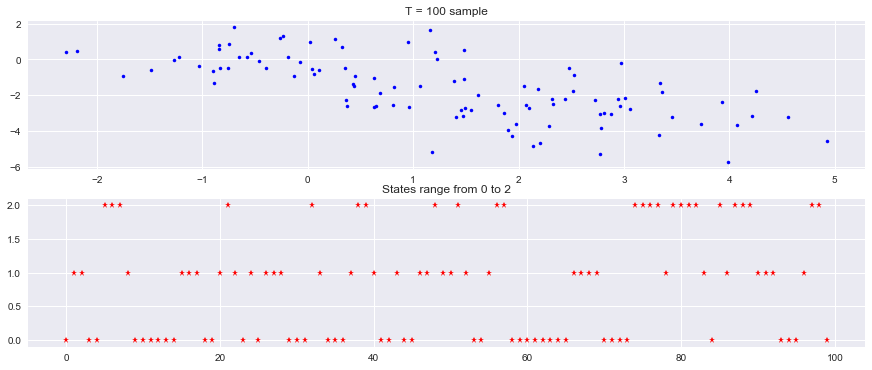

In [4]:
T = 100
pi = model.startprob_
A = model.transmat_
means = model.means_
covars = model.covars_
obs, states = get_Gaussian(A, means, covars, pi, T)

plt.figure(figsize = [15,6])
plt.subplot(211)
plt.plot(obs[0].T, obs[1].T,'b.')
plt.title('T = 100 sample')
plt.subplot(212)
plt.plot(states, 'r*')
plt.title('States range from 0 to 2')
plt.show()

## Alpha-Beta Alogrithm

In [5]:
from scipy.stats import multivariate_normal
K = A.shape[0]
pdfs = []
for k in range(K):
    d_k = multivariate_normal(means[k], covars[k]) # the probability distribution given the certain states
    pdfs.append(d_k)

In [6]:
def get_alpha_beta(X, A, means, covars, pi):
    K = A.shape[0] # states
    T = X.shape[0] # number of observations
    a = np.zeros([T, K]) # alpha
    b = np.zeros([T, K]) # beta
    c = np.zeros(T) # normalize constant
    gamma = np.zeros([T, K]) # posterior marginal likelihoods
    states = np.zeros(T) # argmax

    # Initialize alpha and beta:
    for k in range(K):
        a[0, k] = pi[k] * pdfs[k].pdf(X[0])
    
    b[T-1, :] = np.ones(K)
    
    #forward message passing
    for t in range(1, T): # for the index t
        for k in range(K):
            sum_alpha = 0 #initialize sum value
            for j in range(K):
                sum_alpha += A[j, k] * a[t-1, j]  # transition on current states
            a[t, k] = pdfs[k].pdf(X[t]) * sum_alpha
        c[t] = np.sum(a[t]) # since beta = 1 the normalize constant is calculated by the sum of alpha
        a[t] = a[t] / c[t]
    
    #backward message passing
    for t in range(T-2, -1, -1):
        for k in range(K):
            sum_beta = 0
            for j in range(K):
                sum_beta += b[t+1, j] * A[k, j] * pdfs[j].pdf(X[t+1]) #backward
            b[t, k] = sum_beta
        b[t] = b[t] / c[t+1] # normalize beta by dividing the normalize constant
        
    gamma = a*b # posterior marginal likelihoods
    
    # get argmax
    for i in range(T): #select the max gamma for index i
        states[i] = np.argmax(gamma[i])
    return gamma, states

In [7]:
gamma,states_ab = get_alpha_beta(obs.T, A, means, covars, pi)

## Viterbi Alogrithm

In [8]:
def viterbi_method(X, A, pi, transmat):
    
        # init holders
        K = A.shape[0]
        y = []
        V = np.zeros((len(X), K))# num of unique states, this works with the multi-dimension. 
        best_states = np.zeros((len(X), K))
                     
        for t in range(len(X)):
            for j in range(K):
                if t == 0:
                    prev_V = np.log(pi) #initialize prev_V, notice it is log here.
                else:
                    prev_V = V[t-1, :] #take the previous max value
                candidate_list = prev_V + np.log(transmat[:,j]) + np.log(pdfs[j].pdf(X[t]))
                # log transfer here that change products to sum
                best_i = np.argmax(candidate_list) # get the best index, notice the use of argmanx NOT max!
        
                # populate holders
                V[t,j] = candidate_list[best_i]
                best_states[t,j] = int(best_i)
                      
        for t in range(len(X), 0, -1):
            if t == len(X):
                current_state= int(np.argmax(V[t-1, :])) #argmax 
                y.append(current_state)
            else:
                current_state = int(best_states[t, current_state])
                y.append(current_state)
        return list(reversed(y))

In [9]:
states_v = viterbi_method(obs.T, A, pi, transmat)

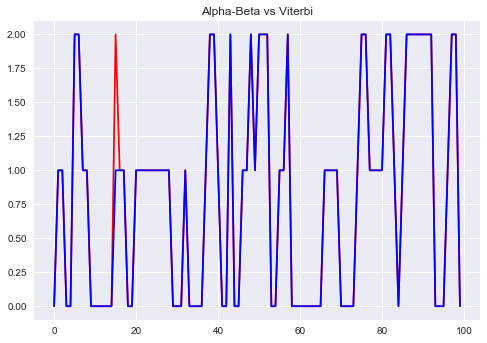

In [10]:
plt.plot(states_ab, 'r-')
plt.title('Alpha-Beta vs Viterbi')
plt.plot(states_v, 'b-')
plt.show()

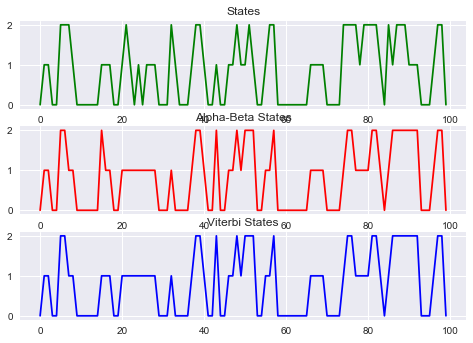

In [11]:
plt.subplot(311)
plt.plot(states, 'g-')
plt.title('States')
plt.subplot(312)
plt.plot(states_ab, 'r-') #alpha-beta state
plt.title('Alpha-Beta States')
plt.subplot(313)
plt.plot(states_v, 'b-')
plt.title('Viterbi States') #viterbi state
plt.show()

The states that I set are really close (by seting close means) to each other and therefore the Viterbi and Alpha-Beta have some slighly difference because of the uncertainty. 

To test the vailidity of the solution, I changed my initial parameters (transition probability) several times. Also, when I choose means with huge difference, the prediction results for both alpha-beta and viterbi are similar, clear and obvious. Another method is to set the trans probability to extreme values such as [1, 0, 0],[0, 1, 0],[0, 0, 1] to see if the result is correct. 

I am also excited to apply the Viterbi algorithm on NLP study!!

Test Code with extreme case

In [12]:
startprob0 = np.array([0.6, 0.1, 0.3])
transmat0 = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])
means0 = np.array([[0.0, 0.0], [1.0, -1.0], [3.0, -3.0]])
# small difference here 
# covars = np.array([[0.49],[0.25],[0.49]]).reshape(3,1,1)

covars0 = np.tile(np.identity(2), (3, 1, 1))

model0 = hmm.GaussianHMM(n_components=3, covariance_type="full")
model0.startprob_ = startprob0
model0.transmat_ = transmat0
model0.means_ = means0
model0.covars_ = covars0

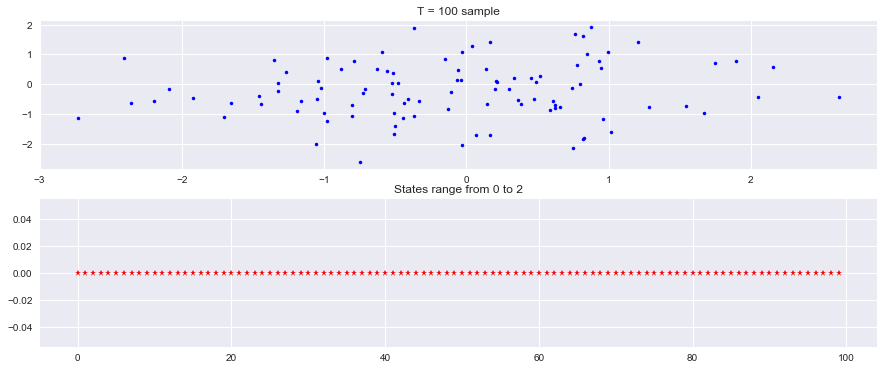

In [13]:
T = 100
pi = model0.startprob_
A = model0.transmat_
means = model0.means_
covars = model0.covars_
obs0, states0 = get_Gaussian(A, means, covars, pi, T)

plt.figure(figsize = [15,6])
plt.subplot(211)
plt.plot(obs0[0].T, obs0[1].T,'b.')
plt.title('T = 100 sample')
plt.subplot(212)
plt.plot(states0, 'r*')
plt.title('States range from 0 to 2')
plt.show()